# Self-Driving Car Engineer Nanodegree


## Project: **Finding Driving Lane Lines on the Road** 
***

As humans, we are naturally able to identify the driving lanes on a road. This is necessary for the vehicles we drive remain within their lane. Naturally, thi is a very important aspect of driving as it minimizes the chances of collisions with other cars.  

This is one of the first things we would expect an autonomous vehicle to perform. Unlike humanity however, computers do not naturally see and when we do empower them with cameras, they do not understand what they see. To detect driving lanes, we can use some well known computer vision techniques. Below, we describe these techniques and show how they can be applied (using Python and OpenCV) to detect driving lanes.  

We start by developing a pipeline on a series of individual images. Later we show how this can easily be extended to videos (which are really just a series of images).   

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [464]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


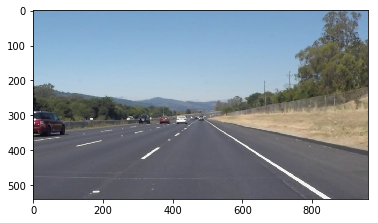

In [465]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [496]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """ 
        
    x=[]
    y=[]
    slope=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            x.append(x1)
            x.append(x2)
            
            y.append(y1)
            y.append(y2)
            
            slope.append((y2-y1)/(x2-x1))
            slope.append((y2-y1)/(x2-x1))
            
    x_array = np.array(x)
    y_array = np.array(y)
    slope_array = np.array(slope)
    
    # limit to only y values within look_ahead range
    # this effectively limits how far ahead we are looking
    
    look_ahead = 0
    
    y_index = np.where(y_array>look_ahead)
    
    x_array = x_array[y_index]
    y_array = y_array[y_index]
    slope_array = slope_array[y_index]

    # seperate into left and right lines using mid_point
    
    mid_point = np.int(img.shape[1]/2)
    #mid_point = np.median(x_array)
    
    #min_point = np.percentile(x_array, 40)
    #max_point = np.percentile(x_array, 60)
    #mid_point = np.mean(x_array[(x_array>min_point) & (x_array<max_point)])
    
    left_x_index = np.where(x_array<mid_point)
    right_x_index = np.where(x_array>mid_point)
    
    #left_x_index = np.where((x_array<mid_point) & (x_array>min_point))
    #right_x_index = np.where((x_array>mid_point) & (x_array<max_point))

    left_x = x_array[left_x_index]
    left_y = y_array[left_x_index]
    
    right_x = x_array[right_x_index]
    right_y = y_array[right_x_index]
    
    # seperate into left and right lines using slope
    
    #left_x_index = np.where((slope_array>0.3) & (slope_array<math.inf))
    #right_x_index = np.where((slope_array<-0.3) & (slope_array>-math.inf))

    #left_x = x_array[left_x_index]
    #left_y = y_array[left_x_index]
    
    #right_x = x_array[right_x_index]
    #right_y = y_array[right_x_index]

    # calculate line-of-best-fit for left and right seperately
    
    line_y_limit = np.int(img.shape[0]*(6/10))
    
    left_m, left_b = np.polyfit(x=left_x, y=left_y, deg=1)
    right_m, right_b = np.polyfit(x=right_x, y=right_y, deg=1)

    left_y1 = line_y_limit
    left_x1 = np.int((left_y1-left_b)/left_m)
    
    left_y2 = img.shape[0]
    left_x2 = np.int((left_y2-left_b)/left_m)
    
    right_y1 = line_y_limit
    right_x1 = np.int((right_y1-right_b)/right_m)
    
    right_y2 = img.shape[0]
    right_x2 = np.int((right_y2-right_b)/right_m)
    
    # add lines to image
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [497]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg']

In [498]:
test_img_dir = "test_images/"

original_image_names = os.listdir(test_img_dir)
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))
print(original_image_names)

['test_images/solidYellowLeft.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [527]:
def show_image_list(img_list, 
                    cols=3, 
                    fig_size=(15, 5), 
                    img_labels=original_image_names, 
                    show_ticks=True):
    
    """
    Convenience function used to show a list of images
    This function is borrowed from: 
    https://github.com/kenshiro-o/CarND-LaneLines-P1/blob/master/Lane_Detection_Term_1.ipynb
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    cmap = None
    
    plt.figure(figsize=fig_size)
    
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
        
        if len(img.shape) < 3:
            cmap = "gray"
        
        if not show_ticks:
            plt.xticks([])
            plt.yticks([])
            
        plt.title(img_name[len(test_img_dir):])    
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

In [559]:
def save_image_list(img_list, 
                    img_names, 
                    folder_path):
    
    """
    Convenience function to save a list of images
    """

    img_count = len(img_list)

    for i in range(0, img_count):

        img_name = img_names[i]

        img = img_list[i]

        name = (img_name[len(test_img_dir):])
        matplotlib.image.imsave(arr=img, 
                                fname= folder_path + name + '.png')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [528]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

We have some sample images of 960 x 540 pixels to train our pipeline against.  
Let's take a look at these below.  

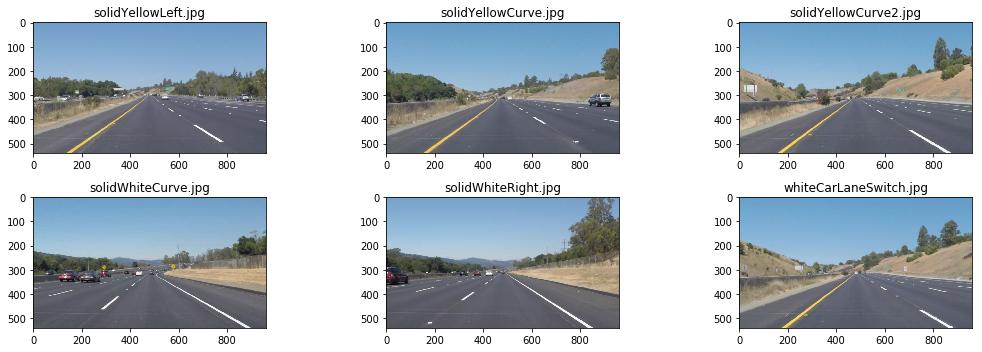

In [529]:
original_images = list(map(lambda img: mpimg.imread(img), 
                           original_image_names))

show_image_list(img_list = original_images)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. While the lane lines are generally coloured white, they can also be yellow. 
2. While most of these images depict only light traffic, some of them have other cars in them and what's worse is that some cars are colored white! 
3. All of these images depict fairly straight patches of road. It is obviously possible for roads and therefore our lane lines to be curved.   

### Pipeline introduction

Our proposed pipeline will look roughly as follows:  
- Convert image to grayscale 
- Apply Gaussian Blur to smoothen edges
- Apply Canny Edge Detection to detect edges
- Extract only edges in our region Of interest
- Perform a Hough Transform to find lanes
- Separate left and right lanes
- Find lines of best fit for both left and right lanes
- Overlay lines over original image

The input to each step is the output of the previous step.  

### Pipeline implementation

In this section, we cover in detail eacg of the steps needed to create our pipeline. 

#### Grayscale 

First we start by converting our images to grayscale.  

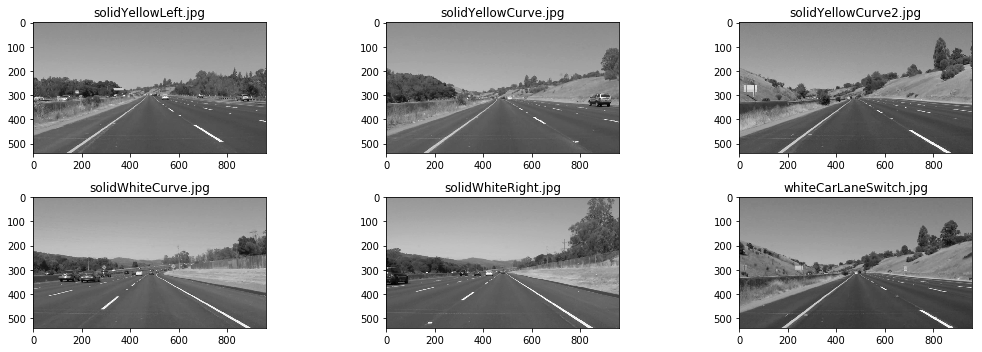

In [530]:
grayscale_images = list(map(lambda img: grayscale(img), 
                            original_images))

show_image_list(img_list = grayscale_images)

#### Blur images

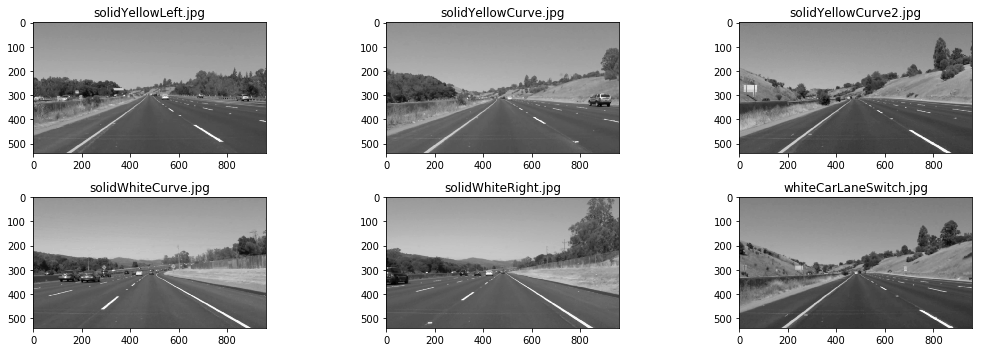

In [531]:
blur_images = list(map(lambda img: gaussian_blur(img, kernel_size=5), 
                            grayscale_images))

show_image_list(img_list = blur_images)

#### Detect edges 

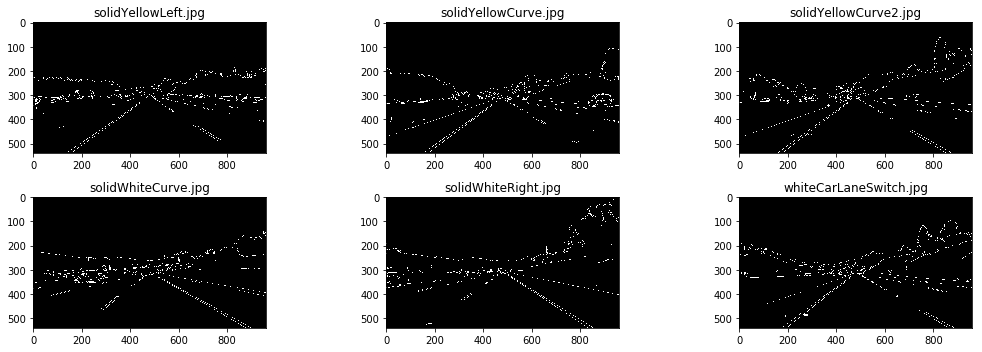

In [532]:
edge_images = list(map(lambda img: canny(img=img, 
                                         low_threshold=50, 
                                         high_threshold=150), 
                       blur_images))

show_image_list(img_list = edge_images)

#### Isolate region of interest 

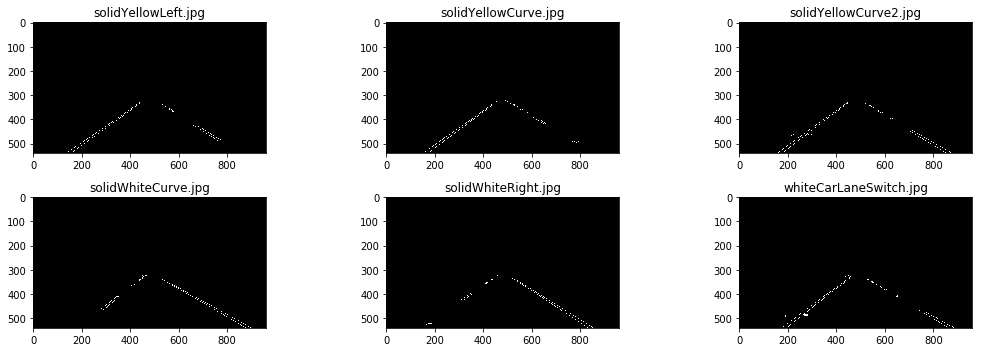

In [533]:
# Define a quadrilateral
vert = np.array([[(0,imshape[0]),
                      (450, 320), 
                      (490, 320), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)

masked_images = list(map(lambda img: region_of_interest(img=img, 
                                                      vertices=vert), 
                       edge_images))

show_image_list(img_list = masked_images)

#### Draw lines

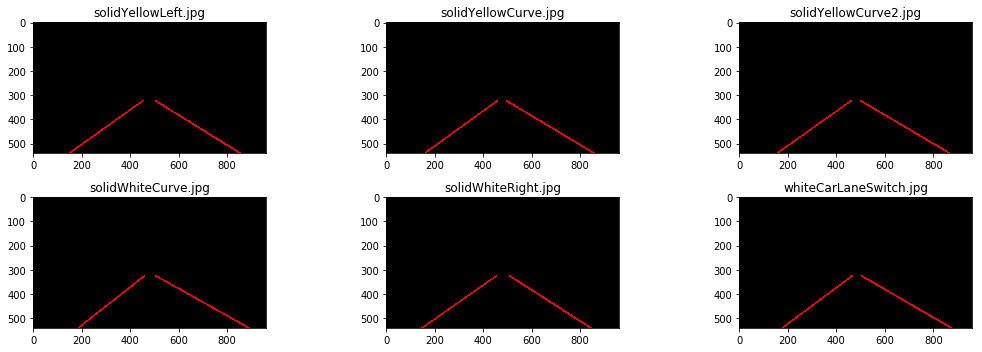

In [534]:
# Define the Hough transformation parameters
# distance resolution in pixels of the Hough grid
rho = 1 

# angular resolution in radians of the Hough grid
theta = np.pi/180 

# minimum number of votes (intersections in Hough grid cell)
threshold = 1     

#minimum number of pixels making up a line
min_line_length = 1

# maximum gap in pixels between connectable line segments
max_line_gap = 1 

hough_line_images = list(map(lambda img: hough_lines(img=img, 
                                                     rho=rho,
                                                     theta=theta,
                                                     threshold=threshold,
                                                     max_line_gap=max_line_gap, 
                                                     min_line_len=min_line_length), 
                       masked_images))

show_image_list(img_list = hough_line_images)

#### Overlay lines and image

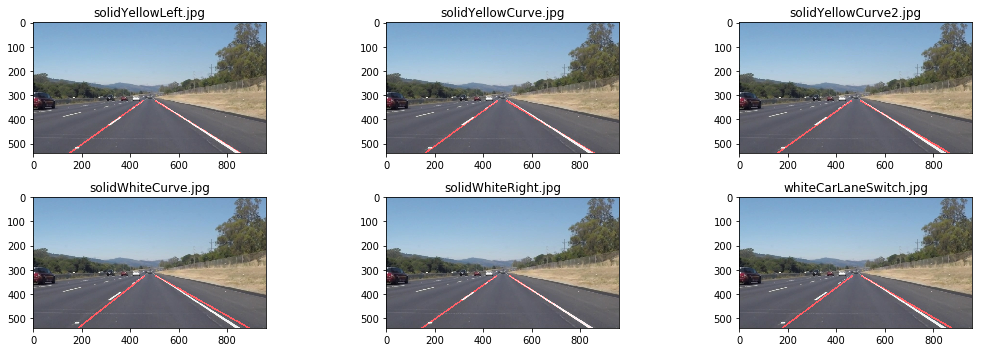

In [535]:
overlay_images = list(map(lambda img: weighted_img(img=img,
                                                   initial_img=image, 
                                                   α=1, 
                                                   β=0.8, 
                                                   λ=0), 
                       hough_line_images))

show_image_list(img_list = overlay_images)

#### Bring it all together

Now let's combine all of the above functions into one with our best parameters.  

In [536]:
def process_image(image, show_plots=False):
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    if show_plots==True:
        plt.imshow(image)
        plt.show()
    
    # convert image to gray scale
    image_gray = grayscale(image)
    
    if show_plots==True:
        plt.imshow(image_gray, cmap='gray')
        plt.show()

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(img=image_gray, 
                              kernel_size=5)
    
    if show_plots==True:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()

    # apply canny edge detection
    edges = canny(img=blur_gray, 
                  low_threshold=50, 
                  high_threshold=150)
    
    if show_plots==True:
        plt.imshow(edges, cmap='gray')
        plt.show()

    # isolate region of interest
    imshape = image.shape

    vert = np.array([[(0,imshape[0]),
                      (450, 320), 
                      (490, 320), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)

    masked = region_of_interest(img=edges, vertices=vert)
    
    if show_plots==True:
        plt.imshow(masked, cmap='gray')
        plt.show()

    # Define the Hough transformation parameters
    # distance resolution in pixels of the Hough grid
    rho = 1 

    # angular resolution in radians of the Hough grid
    theta = np.pi/180 

    # minimum number of votes (intersections in Hough grid cell)
    threshold = 1     

    #minimum number of pixels making up a line
    min_line_length = 1

    # maximum gap in pixels between connectable line segments
    max_line_gap = 1 

    # creating a blank to draw lines on
    #line_image = np.copy(image)*0 

    color_edges = hough_lines(img=masked, 
                              rho=rho,
                              theta=theta,
                              threshold=threshold,
                              max_line_gap=max_line_gap, 
                              min_line_len=min_line_length
                             )
    if show_plots==True:
        plt.imshow(color_edges)
        plt.show()
    
    color_edges_overlaid = weighted_img(img=color_edges,
                                        initial_img=image, 
                                        α=1, 
                                        β=0.8, 
                                        λ=0)
    
    if show_plots==True:
        plt.imshow(color_edges_overlaid)
        plt.show()
    else: 
        #return np.concatenate((image_gray, masked), axis=1)
        #return np.hstack((image_gray, masked))
        return color_edges_overlaid

Lets test our function on all the images to see how well it worked.  

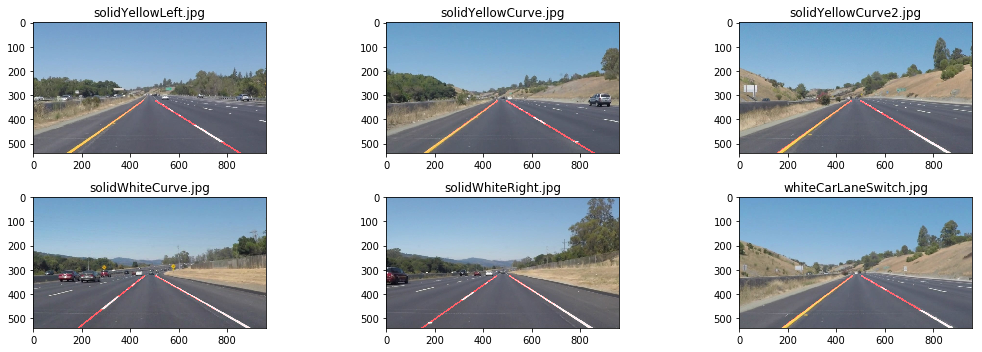

In [537]:
all_test_images = list(map(lambda img: process_image(img, show_plots=False), 
                           original_images))

show_image_list(img_list=all_test_images)

In [560]:
save_image_list(img_list = all_test_images,
                img_names = original_image_names, 
                folder_path = 'test_images_output/')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [538]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [539]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 0/222 [00:00<?, ?it/s]WARNING:py.warnings:/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in int_scalars


100%|█████████▉| 221/222 [00:03<00:00, 60.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.9 s, sys: 152 ms, total: 2.05 s
Wall time: 4.13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [540]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [541]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 0/682 [00:00<?, ?it/s]WARNING:py.warnings:/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in int_scalars


100%|█████████▉| 681/682 [00:11<00:00, 59.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.12 s, sys: 436 ms, total: 6.56 s
Wall time: 11.9 s


In [542]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [543]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]WARNING:py.warnings:/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in int_scalars


100%|██████████| 251/251 [00:08<00:00, 28.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.38 s, sys: 264 ms, total: 5.64 s
Wall time: 9.84 s


In [544]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))